In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

2023-06-15 23:45:04.654494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 23:45:04.687986: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 23:45:04.688537: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 23:45:05.215962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [3]:
dfp['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

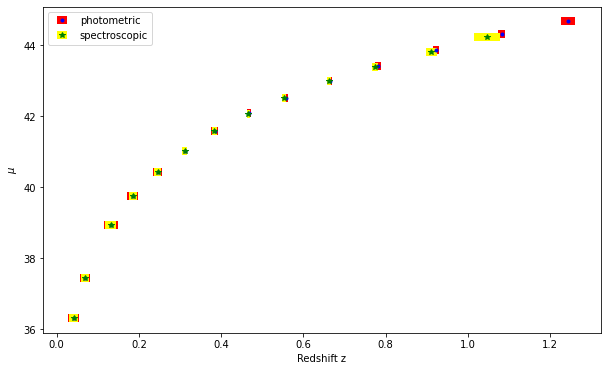

In [4]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(dfp['zCMB'].values, dfp['MU'].values, xerr=dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.errorbar(dfs['zCMB'].values, dfs['MU'].values, xerr=dfs['MUERR_SYS'].values+dfs['MUERR_SYS'].values, fmt='*', color='g', elinewidth=8, ecolor='yellow', label='spectroscopic')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [5]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [6]:
dfp = dfp[['zCMB', 'MU', 'errors']]

In [7]:
dfp.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01348
1,0.06876,37.44798,0.01254
2,0.13121,38.94492,0.01736
3,0.18499,39.75545,0.01316
4,0.24503,40.42469,0.01180


In [8]:
randomize = np.random.permutation(Np)
data_p = dfp.values[randomize]

z = data_p[:,0]
y = data_p[:,1:]

In [9]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [10]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [11]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [12]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((11, 1), (11, 1), (3, 1), (3, 1))

In [13]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 2
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100, 200, 150])
model.summary()


2023-06-15 23:45:06.204251: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-15 23:45:06.204285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: isidro-PC
2023-06-15 23:45:06.204293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: isidro-PC
2023-06-15 23:45:06.204408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.105.17
2023-06-15 23:45:06.204432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.105.17
2023-06-15 23:45:06.204438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.105.17


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 MCDropout_1 (MCDropout)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               30150     
                                                                 
 MCDropout_3 (MCDropout)     (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3

In [ ]:
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1000, verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/1000
6/6 [==============================] - 1s 22ms/step - loss: 851.2102 - val_loss: 867.0630
Epoch 2/1000
6/6 [==============================] - 0s 4ms/step - loss: 839.2486 - val_loss: 835.8746
Epoch 3/1000
6/6 [==============================] - 0s 4ms/step - loss: 826.7535 - val_loss: 814.9843
Epoch 4/1000
6/6 [==============================] - 0s 4ms/step - loss: 806.2872 - val_loss: 775.7064
Epoch 5/1000
6/6 [==============================] - 0s 4ms/step - loss: 767.6808 - val_loss: 708.9456
Epoch 6/1000
6/6 [==============================] - 0s 4ms/step - loss: 731.3445 - val_loss: 611.8348
Epoch 7/1000
6/6 [==============================] - 0s 5ms/step - loss: 661.2460 - val_loss: 473.5267
Epoch 8/1000
6/6 [==============================] - 0s 4ms/step - loss: 553.8816 - val_loss: 304.3357
Epoch 9/1000
6/6 [==============================] - 0s 4ms/step - loss: 421.9336 - val_loss: 84.8847
Epoch 10/1000
6/6 [==============================] - 0s 4ms/step - loss: 281.8381 

6/6 [==============================] - 0s 4ms/step - loss: 28.0122 - val_loss: 176.3388
Epoch 82/1000
6/6 [==============================] - 0s 4ms/step - loss: 21.8158 - val_loss: 117.2949
Epoch 83/1000
6/6 [==============================] - 0s 4ms/step - loss: 18.6001 - val_loss: 33.8247
Epoch 84/1000
6/6 [==============================] - 0s 4ms/step - loss: 5.7375 - val_loss: 18.9794
Epoch 85/1000
6/6 [==============================] - 0s 4ms/step - loss: 21.9427 - val_loss: 34.5151
Epoch 86/1000
6/6 [==============================] - 0s 4ms/step - loss: 12.7115 - val_loss: 91.8828
Epoch 87/1000
6/6 [==============================] - 0s 4ms/step - loss: 9.6804 - val_loss: 166.7243
Epoch 88/1000
6/6 [==============================] - 0s 4ms/step - loss: 19.5023 - val_loss: 65.4718
Epoch 89/1000
6/6 [==============================] - 0s 4ms/step - loss: 12.4892 - val_loss: 88.9660
Epoch 90/1000
6/6 [==============================] - 0s 4ms/step - loss: 21.3055 - val_loss: 98.0731
Epo

Epoch 162/1000
6/6 [==============================] - 0s 4ms/step - loss: 9.2577 - val_loss: 24.7244
Epoch 163/1000
6/6 [==============================] - 0s 4ms/step - loss: 14.4680 - val_loss: 55.7423
Epoch 164/1000
6/6 [==============================] - 0s 4ms/step - loss: 13.4348 - val_loss: 78.3558
Epoch 165/1000
6/6 [==============================] - 0s 4ms/step - loss: 18.8119 - val_loss: 4.2701
Epoch 166/1000
6/6 [==============================] - 0s 4ms/step - loss: 10.8574 - val_loss: 9.5179
Epoch 167/1000
6/6 [==============================] - 0s 4ms/step - loss: 7.5945 - val_loss: 31.1603
Epoch 168/1000
6/6 [==============================] - 0s 4ms/step - loss: 6.2414 - val_loss: 39.6128
Epoch 169/1000
6/6 [==============================] - 0s 4ms/step - loss: 21.4063 - val_loss: 15.2784
Epoch 170/1000
6/6 [==============================] - 0s 4ms/step - loss: 6.0693 - val_loss: 41.9811
Epoch 171/1000
6/6 [==============================] - 0s 4ms/step - loss: 6.6417 - val_l

6/6 [==============================] - 0s 4ms/step - loss: 11.9078 - val_loss: 45.3386
Epoch 243/1000
6/6 [==============================] - 0s 4ms/step - loss: 8.4511 - val_loss: 2.1143
Epoch 244/1000
6/6 [==============================] - 0s 4ms/step - loss: 6.3000 - val_loss: 28.0445
Epoch 245/1000
6/6 [==============================] - 0s 4ms/step - loss: 10.4129 - val_loss: 72.4215
Epoch 246/1000
6/6 [==============================] - 0s 5ms/step - loss: 11.3417 - val_loss: 103.4582
Epoch 247/1000
6/6 [==============================] - 0s 5ms/step - loss: 6.6444 - val_loss: 35.2580
Epoch 248/1000
6/6 [==============================] - 0s 4ms/step - loss: 11.2941 - val_loss: 19.3365
Epoch 249/1000
6/6 [==============================] - 0s 4ms/step - loss: 5.1988 - val_loss: 25.0226
Epoch 250/1000
6/6 [==============================] - 0s 4ms/step - loss: 8.8347 - val_loss: 63.8137
Epoch 251/1000
6/6 [==============================] - 0s 4ms/step - loss: 30.0441 - val_loss: 12.5455


6/6 [==============================] - 0s 4ms/step - loss: 19.0006 - val_loss: 6.6404
Epoch 324/1000
6/6 [==============================] - 0s 4ms/step - loss: 23.1898 - val_loss: 2.5163
Epoch 325/1000
6/6 [==============================] - 0s 4ms/step - loss: 7.9526 - val_loss: 6.9150
Epoch 326/1000
6/6 [==============================] - 0s 4ms/step - loss: 18.1523 - val_loss: 122.4622
Epoch 327/1000
6/6 [==============================] - 0s 4ms/step - loss: 19.4393 - val_loss: 17.9539
Epoch 328/1000
6/6 [==============================] - 0s 4ms/step - loss: 15.0912 - val_loss: 25.1447
Epoch 329/1000
6/6 [==============================] - 0s 4ms/step - loss: 10.6066 - val_loss: 25.0057
Epoch 330/1000
6/6 [==============================] - 0s 5ms/step - loss: 3.9839 - val_loss: 22.8487
Epoch 331/1000
6/6 [==============================] - 0s 4ms/step - loss: 12.9667 - val_loss: 14.4272
Epoch 332/1000
6/6 [==============================] - 0s 4ms/step - loss: 8.2666 - val_loss: 10.2461


6/6 [==============================] - 0s 4ms/step - loss: 7.8581 - val_loss: 42.6102
Epoch 405/1000
6/6 [==============================] - 0s 4ms/step - loss: 6.7854 - val_loss: 4.0553
Epoch 406/1000
6/6 [==============================] - 0s 4ms/step - loss: 4.3630 - val_loss: 13.1819
Epoch 407/1000
6/6 [==============================] - 0s 4ms/step - loss: 15.4350 - val_loss: 0.8760
Epoch 408/1000
6/6 [==============================] - 0s 4ms/step - loss: 19.1551 - val_loss: 5.6518
Epoch 409/1000
6/6 [==============================] - 0s 4ms/step - loss: 5.2990 - val_loss: 4.1176
Epoch 410/1000
6/6 [==============================] - 0s 4ms/step - loss: 6.3165 - val_loss: 62.4876
Epoch 411/1000
6/6 [==============================] - 0s 4ms/step - loss: 8.8632 - val_loss: 26.7789
Epoch 412/1000
6/6 [==============================] - 0s 4ms/step - loss: 10.7182 - val_loss: 37.0745
Epoch 413/1000
6/6 [==============================] - 0s 4ms/step - loss: 5.8916 - val_loss: 5.6069
Epoch 4

6/6 [==============================] - 0s 4ms/step - loss: 8.2199 - val_loss: 5.2755
Epoch 486/1000
6/6 [==============================] - 0s 4ms/step - loss: 10.9175 - val_loss: 8.2394
Epoch 487/1000
6/6 [==============================] - 0s 4ms/step - loss: 9.1598 - val_loss: 17.3445
Epoch 488/1000
6/6 [==============================] - 0s 4ms/step - loss: 12.2929 - val_loss: 6.8002
Epoch 489/1000
6/6 [==============================] - 0s 4ms/step - loss: 19.8102 - val_loss: 10.8213
Epoch 490/1000
6/6 [==============================] - 0s 4ms/step - loss: 13.2807 - val_loss: 18.2355
Epoch 491/1000
6/6 [==============================] - 0s 4ms/step - loss: 13.7424 - val_loss: 47.4517
Epoch 492/1000
6/6 [==============================] - 0s 4ms/step - loss: 8.2065 - val_loss: 14.1415
Epoch 493/1000
6/6 [==============================] - 0s 4ms/step - loss: 7.3389 - val_loss: 11.1524
Epoch 494/1000
6/6 [==============================] - 0s 4ms/step - loss: 9.9956 - val_loss: 8.1552
Epoc

6/6 [==============================] - 0s 4ms/step - loss: 11.5124 - val_loss: 16.8706
Epoch 567/1000
6/6 [==============================] - 0s 4ms/step - loss: 7.9318 - val_loss: 29.8004
Epoch 568/1000
6/6 [==============================] - 0s 4ms/step - loss: 8.0369 - val_loss: 11.4652
Epoch 569/1000
6/6 [==============================] - 0s 4ms/step - loss: 4.9409 - val_loss: 15.6200
Epoch 570/1000
6/6 [==============================] - 0s 4ms/step - loss: 17.7414 - val_loss: 17.0117
Epoch 571/1000
6/6 [==============================] - 0s 4ms/step - loss: 4.9268 - val_loss: 14.9435
Epoch 572/1000
6/6 [==============================] - 0s 4ms/step - loss: 7.0871 - val_loss: 21.9049
Epoch 573/1000
6/6 [==============================] - 0s 4ms/step - loss: 3.4928 - val_loss: 17.6715
Epoch 574/1000
6/6 [==============================] - 0s 4ms/step - loss: 11.2034 - val_loss: 9.0643
Epoch 575/1000
6/6 [==============================] - 0s 4ms/step - loss: 12.6200 - val_loss: 4.9092
Epo

6/6 [==============================] - 0s 4ms/step - loss: 16.7430 - val_loss: 27.9573
Epoch 648/1000
6/6 [==============================] - 0s 4ms/step - loss: 20.4779 - val_loss: 46.7804
Epoch 649/1000
6/6 [==============================] - 0s 4ms/step - loss: 5.2735 - val_loss: 3.8086
Epoch 650/1000
6/6 [==============================] - 0s 4ms/step - loss: 6.9593 - val_loss: 13.2904
Epoch 651/1000
6/6 [==============================] - 0s 4ms/step - loss: 7.0667 - val_loss: 5.0079
Epoch 652/1000
6/6 [==============================] - 0s 4ms/step - loss: 10.8621 - val_loss: 7.9360
Epoch 653/1000
6/6 [==============================] - 0s 4ms/step - loss: 6.1714 - val_loss: 4.7017
Epoch 654/1000
6/6 [==============================] - 0s 4ms/step - loss: 6.0306 - val_loss: 10.0955
Epoch 655/1000
6/6 [==============================] - 0s 5ms/step - loss: 6.0145 - val_loss: 3.0207
Epoch 656/1000
6/6 [==============================] - 0s 5ms/step - loss: 13.0706 - val_loss: 6.4739
Epoch 6

In [ ]:
model_train.history['val_loss'][-1]

In [ ]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 1.5, test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



In [ ]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(dfp['zCMB'], dfp['MU']-19, dfp['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.5)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 50)
